In [1]:
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from output_utils.utils import plot
from supporting_func.supporting_func import convert_dftimetodate, time_segments_aggregate, time_segments_aggregate
from global_variables.global_variables import filename_train, all_activities, filename_test, filename_summary
from orion.primitives.tadgan import TadGAN

Using TensorFlow backend.


In [2]:
    
df = pd.read_csv(filename_train)
df = df[all_activities]

In [3]:
#here df is the given dataframe and "timestamp" is the required column to be altered.
X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')
print(X)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [4]:
#importing sklearn module
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

#Using the simple scikit imputer
imp = SimpleImputer()
X = imp.fit_transform(X)

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
print(X.shape)

(3070, 1)


In [6]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)
#the target value; the value at time t.
#previous observed values, this is determined by the window width.
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [7]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (2970, 100, 1)
Training data index shape: (2970,)
Training y shape: (2970, 1)
Training y index shape: (2970,)


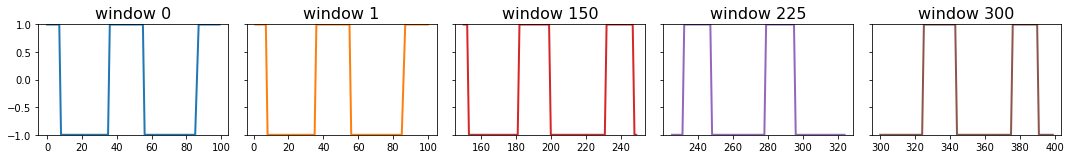

In [9]:
from output_utils.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts
#function from utils.py module. Representing all the windows that has been created by slicing
#Here X represents the input used to train the model. In the previous example, we see X has 10222 training data points.
#Notice that 100 represents the window size. On the other hand, y is the real signal after processing, 
#which we will use later on to calculate the error between the reconstructed and real signal.
plot_rws(X, 100)

In [10]:
from config.model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 10
hyperparameters["input_shape"] = (100, 1)
hyperparameters["target_shape"] = (100, 1) 
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64
hyperparameters["layers_generator"][1]["parameters"]["units"] = int(100/2)

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

model shape x (?, 100, 1)
model shape x (?, 20, 1)
model shape x (?, 100, 1)
model shape x (?, 20, 1)


/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-20 09:54:06.446632: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-08-20 09:54:06.494008: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb7b50ceff0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-20 09:54:06.494022: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-20 09:54:22.551465: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-08-20 09:54:22.582818: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iter

Epoch: 1/10, [Dx loss: [-4.0301623  -8.075455    0.6382779   0.34070158]] [Dz loss: [ 2.787045   -0.03371082  2.0084097   0.08123466]] [G loss: [ 6.560265   -0.62554854 -1.7553664   0.894118  ]]
Epoch: 2/10, [Dx loss: [ -7.3716288  -11.9537735    3.2931905    0.12889552]] [Dz loss: [ -7.44012     -0.23055187 -10.527293     0.3317724 ]] [G loss: [16.864616   -3.33835    15.1562395   0.50467265]]
Epoch: 3/10, [Dx loss: [ -3.6541574  -10.356276     6.2409496    0.04611668]] [Dz loss: [-4.2387667   1.2463151  -7.403951    0.19188695]] [G loss: [ 5.46388    -5.999261    7.9023438   0.35607976]]
Epoch: 4/10, [Dx loss: [-2.4014463  -9.55848     6.831912    0.03251228]] [Dz loss: [ 0.06180827  1.9130511  -2.1900234   0.03387804]] [G loss: [-0.7478188  -6.8082294   2.524975    0.35354355]]
Epoch: 5/10, [Dx loss: [-2.0221293  -8.900038    6.6091146   0.02687962]] [Dz loss: [-0.94077045  1.7470425  -3.1445282   0.04567151]] [G loss: [-0.3932315  -6.4259357   3.1561308   0.28765732]]
Epoch: 6/10, 

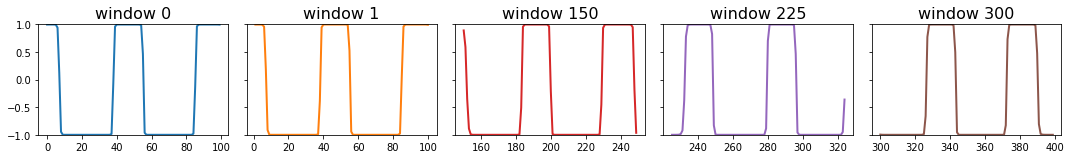

In [11]:
# reconstructing the signal
X_hat, critic = tgan.predict(X)
# visualize X_hat
plot_rws(X_hat, window=100)

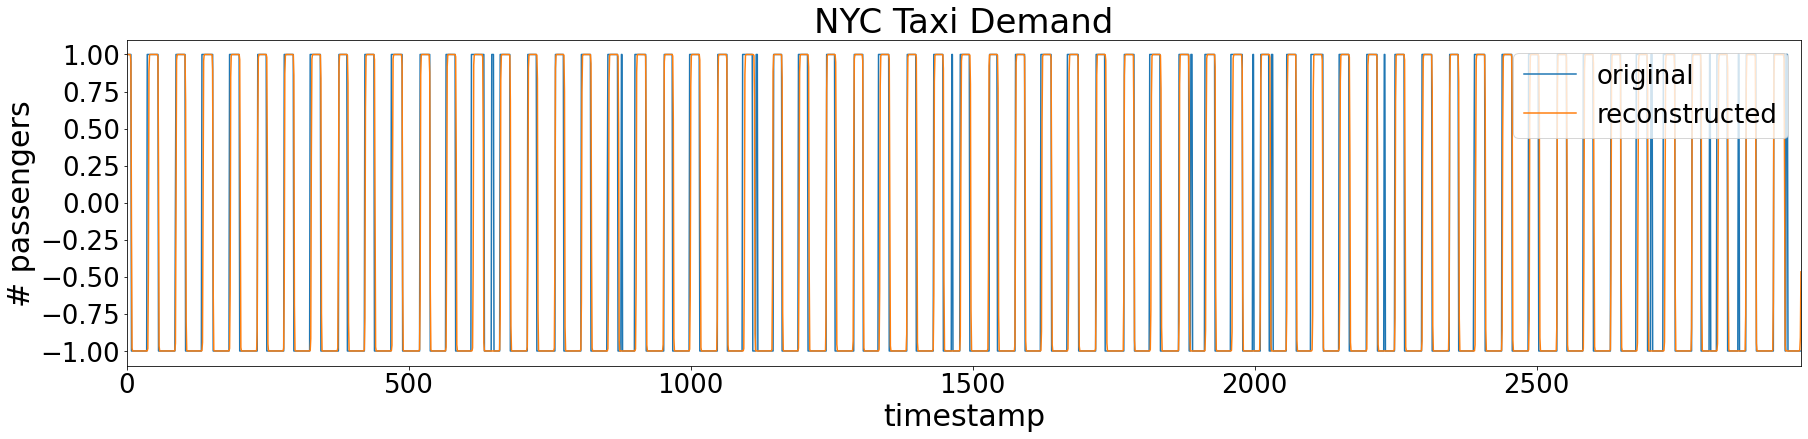

In [12]:
# flatten the predicted windows 
y_hat = unroll_ts(X_hat)
# plot the time series data 
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

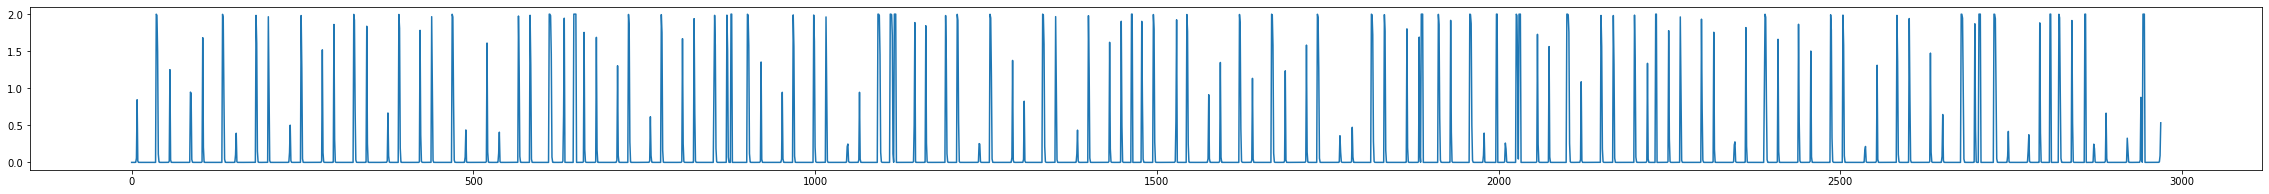

In [13]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(40, 3))
plt.plot(error)
plt.show()

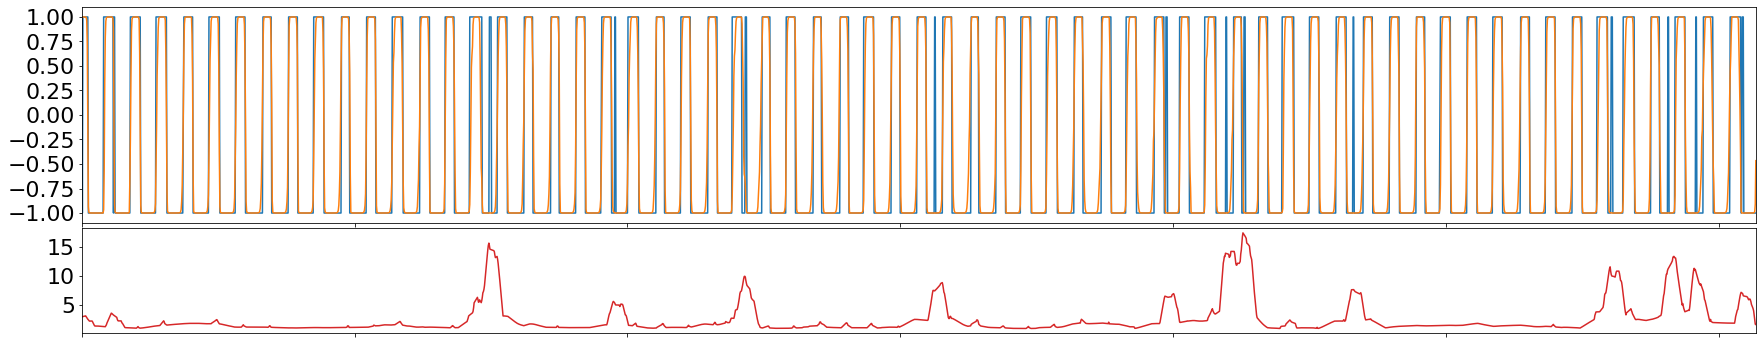

In [14]:
from orion.primitives.tadgan import score_anomalies
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)
# visualize the error curve
plot_error([[true, pred], error])

In [15]:
# threshold to classify the high peak data points as anomolous points
thresh = 5

intervals = list()
print(error.shape)

i = 0
max_start = len(error)
print(max_start)
while i < max_start:
    j = i
    start = index[i]
    while (i < max_start) and (error[i] > thresh):
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

(3069,)
3069


[(1298280, 1391880, 9.953770125734374),
 (1753680, 1778880, 5.202148815267389),
 (1782480, 1789680, 5.138751246801942),
 (2169480, 2225280, 7.441558243895703),
 (2804880, 2857080, 7.456485745966068),
 (3571680, 3616680, 6.284102910455558),
 (3758880, 3877680, 12.894341619698174),
 (4183680, 4232280, 6.8269523224389905),
 (5024280, 5094480, 9.079198594922238),
 (5218680, 5287080, 9.809441934995418),
 (5310480, 5362680, 8.54512904699332),
 (5470680, 5513880, 6.326332583994745)]

                 start                 end      score
0  2012-02-12 00:38:00 2012-02-13 02:38:00   9.953770
1  2012-02-17 07:08:00 2012-02-17 14:08:00   5.202149
2  2012-02-17 15:08:00 2012-02-17 17:08:00   5.138751
3  2012-02-22 02:38:00 2012-02-22 18:08:00   7.441558
4  2012-02-29 11:08:00 2012-03-01 01:38:00   7.456486
5  2012-03-09 08:08:00 2012-03-09 20:38:00   6.284103
6  2012-03-11 12:08:00 2012-03-12 21:08:00  12.894342
7  2012-03-16 10:08:00 2012-03-16 23:38:00   6.826952
8  2012-03-26 03:38:00 2012-03-26 23:08:00   9.079199
9  2012-03-28 09:38:00 2012-03-29 04:38:00   9.809442
10 2012-03-29 11:08:00 2012-03-30 01:38:00   8.545129
11 2012-03-31 07:38:00 2012-03-31 19:38:00   6.326333


TypeError: an integer is required (got type Timestamp)

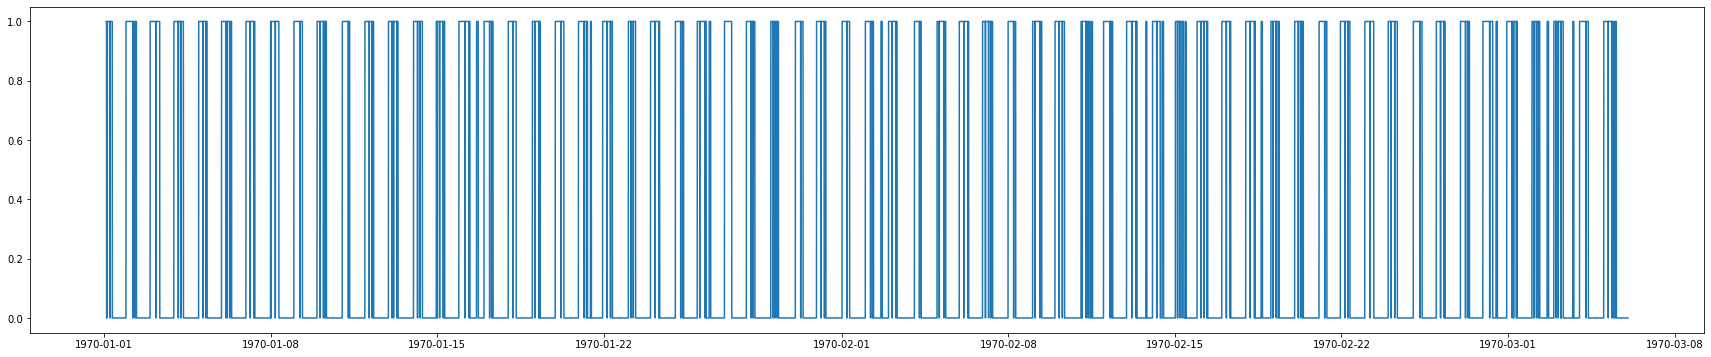

In [16]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
convert_dftimetodate(anomalies)
print(anomalies)
#now plotting the actual data, known anomalies and predicted anomalies
plot(df, [anomalies])